# Scoring model based on decision tree

In [1]:
import os
import warnings
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from dtreeviz.trees import dtreeviz

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
)
from sklearn.pipeline import Pipeline

# Global parameters
N_SPLITS = 5
N_REPEATS = 10
SEED = 42
TRIALS = 150

# Settings
np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `standard number format` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode
sns.set_context("paper", font_scale=1.4)                                  # sns font
sns.set_style("darkgrid")                                                 # sns theme

In [2]:
def objective(trial):
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
    }
    
    model = DecisionTreeClassifier(**param, random_state=SEED)

    # Cross-validation
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_val_auc = scores["test_score"].std()

    return mean_val_auc * 2 - 1

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

print(X_train.shape)
print(X_test.shape)

(20000, 23)
(10000, 23)


### Feature selection

In [4]:
%%time
# Initial hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
print(study.best_params)

[I 2021-05-24 21:28:03,451] A new study created in memory with name: no-name-c57609e6-904d-43a2-ac75-6b5e9978e32e
[I 2021-05-24 21:28:03,919] Trial 3 finished with value: 0.44044323287893894 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 22, 'min_samples_leaf': 38, 'max_features': 'auto', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.44044323287893894.
[I 2021-05-24 21:28:04,091] Trial 0 finished with value: 0.4784406379113879 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 35, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.4784406379113879.
[I 2021-05-24 21:28:04,512] Trial 4 finished with value: 0.5015638625412848 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 36, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.5015638625412848.
[I 2021-05-24 21:28:05,100] Trial 6 finished wit

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 50, 'max_features': None, 'class_weight': 'balanced'}
Wall time: 54.6 s


In [5]:
# Sequential feature selection
model = DecisionTreeClassifier(**study.best_params, random_state=SEED)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
sfs = SequentialFeatureSelector(
    model,
    k_features=23,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    5.0s finished

[2021-05-24 21:29:03] Features: 1/23 -- score: 0.7114870791385071[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-05-24 21:29:04] Features: 2/23 -- score: 0.740027111318707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-05-24 21:29:05] Features: 3/23 -- score: 0.756

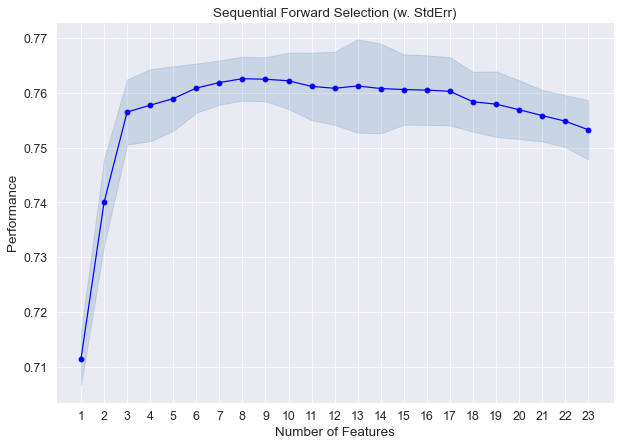

In [6]:
# Plot SFS chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=[10, 7])
plt.title("Sequential Forward Selection (w. StdErr)")

plt.savefig(os.path.join("Experiment_results", "DecisionTree", "dt_SFS.png"), facecolor="w")

In [7]:
# Print chosen variables
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
final_variables = list(results["feature_names"][10])
final_variables

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT5']

In [8]:
# Drop unused variables
X_train = X_train[final_variables]
X_test = X_test[final_variables]

### Model

In [9]:
%%time
start = time.time()

# Hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)

end = time.time()
optimization_time = end-start

print(study.best_params)

# Model definition
model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)

[I 2021-05-24 21:31:40,256] A new study created in memory with name: no-name-0afb9515-78a1-40f4-ad3c-9e3c2f0e57dc
[I 2021-05-24 21:31:40,749] Trial 1 finished with value: 0.46894006127507093 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 29, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.46894006127507093.
[I 2021-05-24 21:31:40,810] Trial 0 finished with value: 0.51477677792897 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.51477677792897.
[I 2021-05-24 21:31:40,958] Trial 3 finished with value: 0.4970490153301945 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.51477677792897.
[I 2021-05-24 21:31:40,990] Trial 2 finished w

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 47, 'min_samples_leaf': 47, 'max_features': None, 'class_weight': None}


NameError: name 'lgb' is not defined

In [10]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_val_auc = scores["test_score"].std()

# Test
model.fit(X=X_train, y=np.ravel(y_train))
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)
ap = metrics.average_precision_score(y_test, 1-preds, pos_label=0)

# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_val_auc * 2 - 1, 4), f"({np.round(std_val_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")
print(f"AP:\t\t\t {np.round(ap, 4)}")

mean_train_GINI:	 0.5375
mean_dev_GINI:		 0.5127 (0.0104)
test_GINI:		 0.5228
AP:			 0.5263


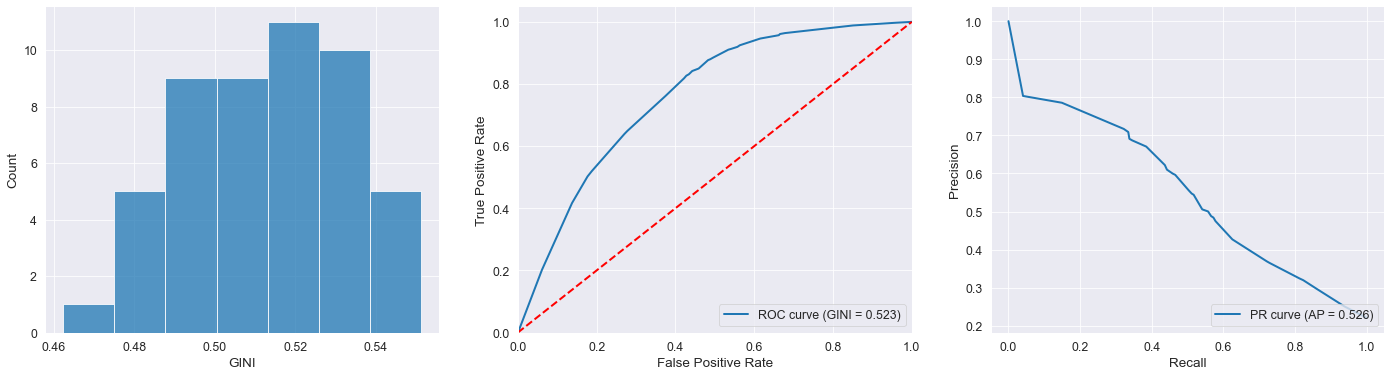

In [11]:
# Boxplot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
fig1 = sns.histplot(scores["test_score"] * 2 - 1, ax=axs[0])
fig1.set_xlabel("GINI")

# ROC
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[1].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, 1-preds, pos_label=0)
lw = 2
axs[2].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % ap)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "DecisionTree", "dt_cv_roc.png"), facecolor="w")

In [12]:
# Save results for final summary
res = {
    "val_scores": scores["test_score"] * 2 - 1,
    "fpr_tpr": [fpr, tpr],
    "pr_rec": [precision, recall],
    "test_gini": test_auc * 2 - 1,
    "dev_gini": [mean_val_auc * 2 - 1, std_val_auc],
    "optimization_time": optimization_time,
    "ap": ap,
}

joblib.dump(res, os.path.join("Experiment_results", "DecisionTree", "dt_res.pth"))

['Experiment_results\\DecisionTree\\dt_res.pth']

                      0       1       2      3       4       5       6       7       8       9       10      11
score_calibrated  547.00  571.00  520.00  510.0  540.00  401.00  508.00  386.00  456.00  467.00  486.00  442.00
%Agreements        18.45   16.75   11.14   10.9    7.53    5.73    5.46    3.08    2.84    2.79    2.64    1.88


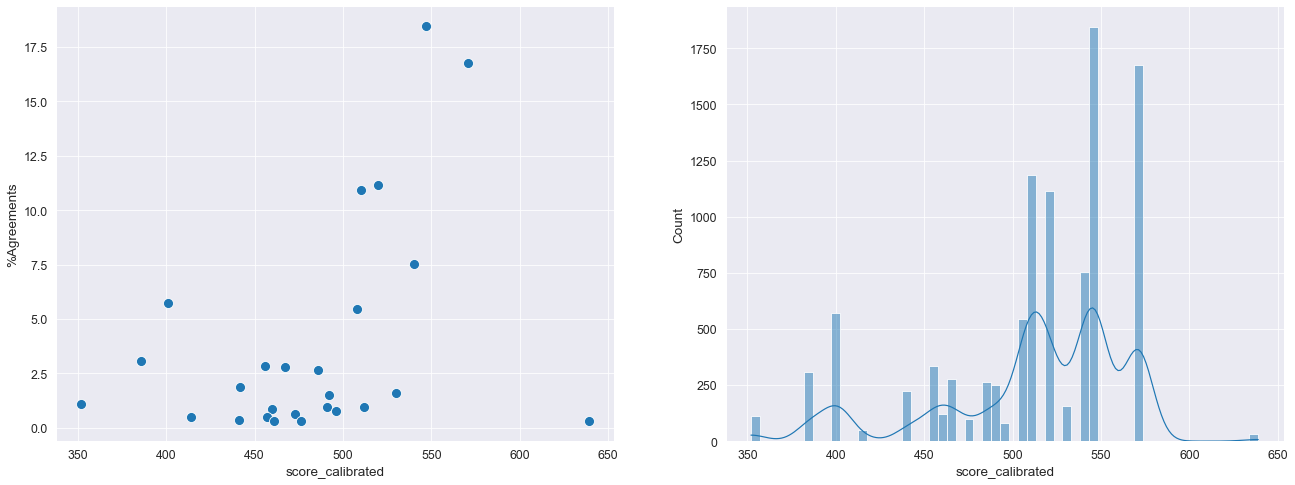

In [13]:
# Score distribution
preds_calibrated = pd.DataFrame(np.round(50*np.log(preds/(1-preds))+500), columns=["score_calibrated"])

score_distr = preds_calibrated['score_calibrated'].value_counts()/preds_calibrated.shape[0]*100
score_distr_df = pd.concat([pd.Series(list(score_distr.index), name='score_calibrated'), pd.Series(list(score_distr), name='%Agreements')], axis=1)
print(score_distr_df.head(12).T.to_string())

fig, axs = plt.subplots(1, 2, figsize=(22,8))
sns.scatterplot(data=score_distr_df, x="score_calibrated", y="%Agreements", s=100, ax=axs[0])
sns.histplot(data=preds_calibrated, x="score_calibrated", kde=True, ax=axs[1])

plt.savefig(os.path.join("Experiment_results", "DecisionTree", "dt_score_distr.png"), facecolor="w")

In [14]:
model.max_depth = 4

In [15]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_val_auc = scores["test_score"].std()

# Test
model.fit(X=X_train, y=np.ravel(y_train))
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)

# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_val_auc * 2 - 1, 4), f"({np.round(std_val_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")
print(f"AP:\t\t\t {np.round(metrics.average_precision_score(y_test, preds), 4)}")

mean_train_GINI:	 0.5178
mean_dev_GINI:		 0.5019 (0.0104)
test_GINI:		 0.518
AP:			 0.8908


In [16]:
plt.figure(figsize=(20, 5), dpi=900)
_ = plot_tree(model,
         filled=True,
         proportion=True,
         precision=2,
         feature_names=X_train.columns,
         class_names=["Bad", "Good"]
         )

plt.savefig(os.path.join("Experiment_results", "DecisionTree", "dt_viz.png"), facecolor="w")

In [17]:
viz = dtreeviz(
        model,
        X_test.to_numpy(),
        y_test.to_numpy().flatten(),
        target_name='Client default',
        feature_names=X_train.columns,
        class_names=["Bad", "Good"])
viz.save(os.path.join("Experiment_results", "DecisionTree", "dt_viz2.svg"))

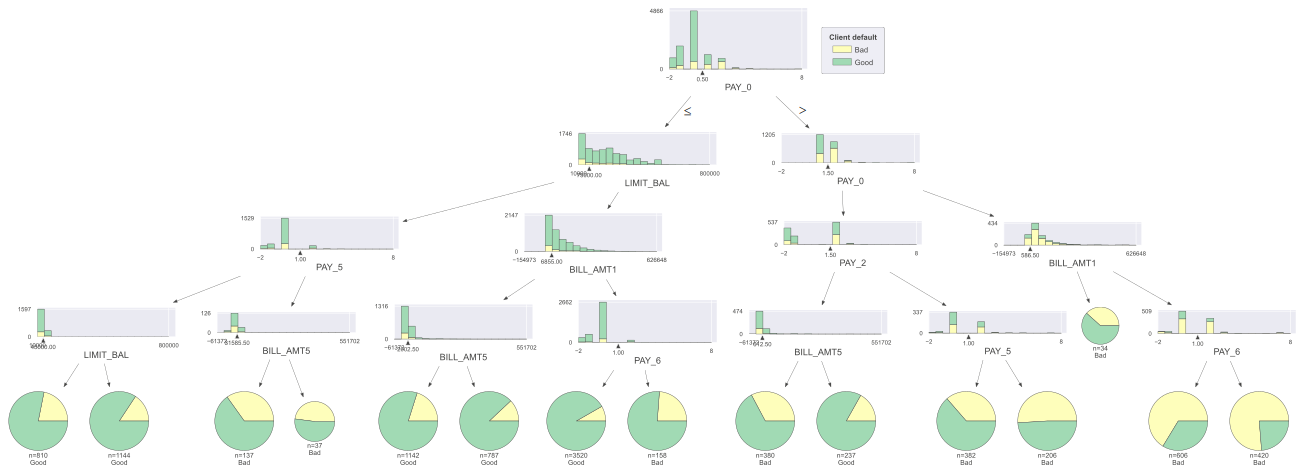

In [18]:
viz

### Performance vs sample size

In [19]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # optuna silent mode

In [20]:
# Examine relationship between model performance and sample size
n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]

experiment = pd.DataFrame(n_sample, columns=["Training set size"])
experiment["Mean train GINI"] = np.NaN
experiment["Mean validation GINI"] = np.NaN
experiment["Std validation GINI"] = np.NaN
experiment["Test GINI"] = np.NaN

for i in range(len(n_sample)):
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))[final_variables]
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))[final_variables]
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

    if n_sample[i] < 20000:
        X_train = X_train.sample(n_sample[i], random_state=SEED)
        y_train = y_train.sample(n_sample[i], random_state=SEED)
        
    # Hyperparameters optimization
    study = optuna.create_study(directions=["maximize"])
    study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
    print(study.best_params)

    # Model definition
    model = DecisionTreeClassifier(**study.best_params, random_state=SEED)    
        
    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_val_auc = scores["test_score"].std()

    # Test
    model.fit(X=X_train, y=np.ravel(y_train))
    preds = model.predict_proba(X_test)[::, 1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Save the results to daraframe
    experiment["Mean train GINI"][i] = mean_train_auc * 2 - 1
    experiment["Mean validation GINI"][i] = mean_val_auc * 2 - 1
    experiment["Std validation GINI"][i] = std_val_auc
    experiment["Test GINI"][i] = test_auc * 2 - 1

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'class_weight': 'balanced'}
{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 39, 'min_samples_leaf': 47, 'max_features': 'log2', 'class_weight': None}
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 26, 'max_features': 'auto', 'class_weight': 'balanced'}
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 25, 'min_samples_leaf': 20, 'max_features': None, 'class_weight': 'balanced'}
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': 'balanced'}
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 39, 'max_features': 'log2', 'class_weight': None}
{'criterion': 'entropy', 'max_depth':

In [21]:
experiment

,Training set size,Mean train GINI,Mean validation GINI,Std validation GINI,Test GINI
0,50,0.607223,0.362798,0.213604,-0.076257
1,100,0.463035,0.293733,0.143530,0.411443
2,500,0.439189,0.389857,0.056679,0.425751
3,1000,0.549166,0.364060,0.042872,0.428676
4,2000,0.573571,0.475663,0.030204,0.487952
5,3000,0.561134,0.449332,0.024222,0.488846
6,5000,0.562309,0.497667,0.021684,0.507325
7,7000,0.541182,0.495730,0.015244,0.510584
8,10000,0.583501,0.517852,0.012679,0.516670
9,20000,0.574989,0.522661,0.009937,0.532305


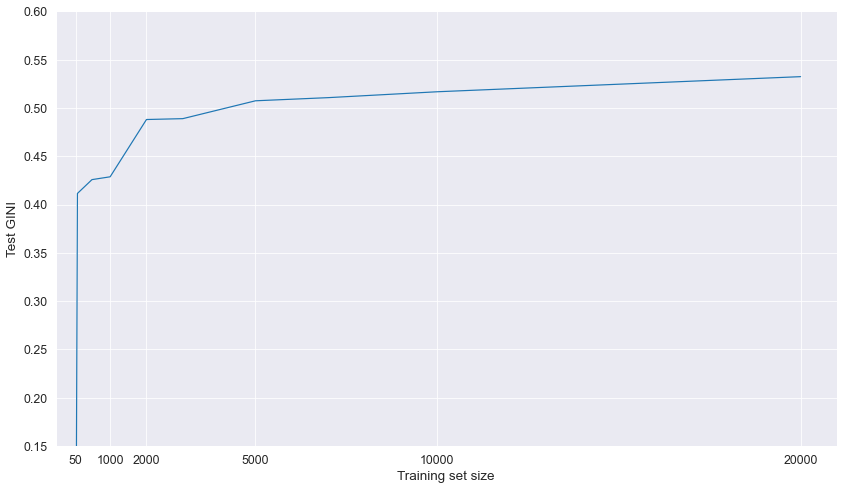

In [22]:
# Plot experiment results
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=experiment, x="Training set size", y="Test GINI")
ax.set_ylim([0.15, 0.6])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [23]:
# Save results for final summary
joblib.dump(experiment, os.path.join("Experiment_results", "DecisionTree", "dt_experiment.pth"))

['Experiment_results\\DecisionTree\\dt_experiment.pth']